Copyright (c) 2023 Habana Labs, Ltd. an Intel Company.
#### Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
# Intel&reg; Gaudi&reg; 2 Model Profiling and Optimization using Swin Transformer from HuggingFace

### Objecive
This tutorial will show the user how to run the Intel Gaudi Profiling tools; the habana_perf_tool and the Tensorboard plug-in on the Intel Gaudi 2 AI Accelerator.  These tools will provide the user valueable optimization tips and information to modify any model for better performance.   For more information, please refer to the [Profiling](https://docs.habana.ai/en/latest/Profiling/index.html) section of the documentation for info on how to setup the profiler and the [Optimization Guide](https://docs.habana.ai/en/latest/PyTorch/Model_Optimization_PyTorch/index.html) for additional background on other optimization techniques.

#### Initial Setup
We start with an Intel Gaudi PyTorch Docker image and run this notebook.   For this example, we'll be using the [Swin Transformer](https://huggingface.co/microsoft/swin-base-patch4-window7-224-in22k) model from the Hugging Face Repository running on Hugging Face's Optimum-Habana library.

#### Install the Optimum Habana Library

In [1]:
!pip install --quiet optimum-habana==1.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.1/244.1 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 277.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 384.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━

  Created wheel for optimum: filename=optimum-1.8.8-py3-none-any.whl size=318455 sha256=2ea2857c786c4385a32099fe4791be36627b7f3eb874093017908ec09333b46c
  Stored in directory: /tmp/pip-ephem-wheel-cache-wjyzd51r/wheels/a0/93/00/e6f8f49a40e3af11f7d883b36482af20073db0520b340e0f24
Successfully built optimum


#### Clone the HuggingFace Model Repository

In [3]:
!git clone -b v1.13.2 https://github.com/huggingface/optimum-habana.git

Cloning into 'optimum-habana'...
remote: Enumerating objects: 4208, done.
remote: Counting objects: 100% (1319/1319), done.
remote: Compressing objects: 100% (517/517), done.
remote: Total 4208 (delta 895), reused 1061 (delta 760), pack-reused 2889
Receiving objects: 100% (4208/4208), 2.24 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (2677/2677), done.


#### Go the image-classification example model and install the requirements

In [1]:
%cd optimum-habana/examples/image-classification

/root/workshop/Gaudi2-Workshop/Model-Optimization/optimum-habana/examples/image-classification


In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 25.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 149.3 MB/s eta 0:00:0000:0100:01


#### Look in utils.py to see torch profiler code
For other models not in optimum-habana, users can refer to [Profiling_with_PyTorch](https://docs.habana.ai/en/latest/Profiling/Profiling_with_PyTorch.html).

In [2]:
%%sh

cat -n ../../optimum/habana/utils.py | head -n 313 | tail -n 13

   245	            schedule = torch.profiler.schedule(wait=wait, warmup=warmup, active=active, repeat=1)
   246	            activities = [torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.HPU]
   247	
   248	            profiler = torch.profiler.profile(
   249	                schedule=schedule,
   250	                activities=activities,
   251	                on_trace_ready=torch.profiler.tensorboard_trace_handler(output_dir),
   252	                record_shapes=True,
   253	                with_stack=True,
   254	            )


#### Run Model to collect trace file (unoptimized)
Swin Transformer is a model that capably serves as a general-purpose backbone for computer vision. `run_image_classification.py` is a script that showcases how to fine-tune Swin Transformer on HPUs.

Notice the Habana specific commands:

`--use_habana` - allows training to run on Habana Gaudi  
`--use_hpu_graphs` - reduces recompilation by replaying the graph  
`--gaudi_config_name Habana/swin` - mapping to HuggingFace Swin Model config 

Notice the torch profiler specific commands:

`--profiling_warmup_steps 10` - profiler will wait for warmup steps  
`--profiling_steps 3` - records for the next active steps 

The collected trace files will be saved to `./hpu_profile`; but copies will be moved to the `./swin_profile` folder for reference.  

In [7]:
!python run_image_classification.py \
--model_name_or_path microsoft/swin-base-patch4-window7-224-in22k \
--dataset_name cifar10 \
--output_dir /tmp/outputs/ \
--remove_unused_columns False \
--image_column_name img \
--do_train \
--learning_rate 3e-5 \
--num_train_epochs 1 \
--per_device_train_batch_size 8 \
--evaluation_strategy no \
--save_strategy no \
--load_best_model_at_end False \
--save_total_limit 3 \
--seed 1337 \
--use_habana \
--use_lazy_mode \
--bf16 \
--use_hpu_graphs_for_training \
--gaudi_config_name Habana/swin \
--throughput_warmup_steps 2 \
--overwrite_output_dir \
--ignore_mismatched_sizes \
--profiling_warmup_steps 10 \
--profiling_steps 3

/usr/local/lib/python3.8/dist-packages/optimum/habana/transformers/training_args.py:252: FutureWarning: `--use_hpu_graphs` is deprecated and will be removed in a future version of 🤗 Optimum Habana. Use `--use_hpu_graphs_for_inference` instead.
  warnings.warn(


06/27/2023 03:10:28 - WARNING - __main__ - Process rank: -1, device: hpu, distributed training: False, mixed-precision training: True
06/27/2023 03:10:28 - INFO - __main__ - Training/evaluation parameters GaudiTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-06,
adjust_throughput=False,
auto_find_batch_size=False,
bf16=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=230,
ddp_find_unused_parameters=False,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
distribution_strategy=ddp,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fsdp_config=None,
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gaudi_config_name=Habana/swin,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
h

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]/usr/local/lib/python3.8/dist-packages/datasets/features/image.py:325: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.



Generating train split: 100%|█████████▉| 49801/50000 [00:12<00:00, 4435.08 examples/s]
                                                                                      

Generating test split:  96%|█████████▋| 9631/10000 [00:02<00:00, 4455.57 examples/s]
                                                                                    

100%|██████████| 2/2 [00:00<00:00, 672.70it/s]


[INFO|configuration_utils.py:668] 2023-06-27 03:10:53,252 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/790d9b6014f6d157cc34d70afc0604eccc92dadd/config.json
[INFO|configuration_utils.py:720] 2023-06-27 03:10:53,256 >> Model config SwinConfig {
  "_name_or_path": "microsoft/swin-base-patch4-window7-224-in22k",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "encoder_stride": 32,
  "finetuning_task": "image-classification",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,


hmp:verbose_mode  False
hmp:opt_level O1


  2%|▏         | 13/665 [00:48<25:14,  2.32s/it]STAGE:2023-06-27 03:11:48 241:241 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-27 03:11:48 241:241 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
100%|██████████| 665/665 [03:27<00:00,  5.12it/s][INFO|trainer.py:1041] 2023-06-27 03:14:26,800 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 665/665 [03:27<00:00,  3.20it/s]
[INFO|trainer.py:1766] 2023-06-27 03:14:26,871 >> Saving model checkpoint to /tmp/outputs/
[INFO|configuration_utils.py:457] 2023-06-27 03:14:27,022 >> Configuration saved in /tmp/outputs/config.json
[INFO|modeling_utils.py:1847] 2023-06-27 03:14:27,309 >> Model weights saved in /tmp/outputs/pytorch_model.bin
[INFO|image_processing_utils.py:203] 2023-06-27 03:14:27,309 >> Image processor saved in /tmp/outputs/preprocessor_config.json
[INFO|configuration_utils.py:113] 2023-06-27 03:14:27,309 >> Configuration sav

{'loss': 0.27, 'learning_rate': 7.443609022556391e-06, 'epoch': 0.75, 'memory_allocated (GB)': 90.52, 'max_memory_allocated (GB)': 92.25, 'total_memory_available (GB)': 93.74}
{'train_runtime': 207.6646, 'train_samples_per_second': 240.412, 'train_steps_per_second': 3.762, 'train_loss': 0.2721804511278195, 'epoch': 1.0, 'memory_allocated (GB)': 90.84, 'max_memory_allocated (GB)': 92.25, 'total_memory_available (GB)': 93.74}
***** train metrics *****
  epoch                       =        1.0
  max_memory_allocated (GB)   =      92.25
  memory_allocated (GB)       =      90.84
  total_memory_available (GB) =      93.74
  train_loss                  =     0.2722
  train_runtime               = 0:03:27.66
  train_samples_per_second    =    240.412
  train_steps_per_second      =      3.762


In [3]:
%ls -al ./hpu_profile

total 746936
drwxr-xr-x 2 root root      4096 Jun 27 03:37 ./
drwxr-xr-x 5 root root      4096 Jun 27 05:49 ../
-rw-r--r-- 1 root root 247277431 Jun 27 03:27 sc09wynn01-hls2_1725.1687836473515.pt.trace.json
-rw-r--r-- 1 root root 270297943 Jun 27 03:12 sc09wynn01-hls2_241.1687835527077.pt.trace.json
-rw-r--r-- 1 root root 247261794 Jun 27 03:37 sc09wynn01-hls2_3618.1687837025280.pt.trace.json


#### Two ways to use HPU Performance Analysis tool

We can launch Tensorboard to see the performance analysis results:
```sh
tensorboard --logdir xxx
```

Or simply use `habana_perf_tool` to see the console output analysis:
```sh
habana_perf_tool --trace xxx.trace.json
```

Notice the contents of `habana_perf_tool` console output:

`Device/Host ratio` - To show the overall performance, device utilization  
`Host Summary` - Host side performance, to show dataloader, graph build, data copy and compile  
`Device Summary` - Device side performance, to show MME, TPC and DMA  
`Host/Device Recommendations` - Performance Recommendations for model optimization

In [10]:
%ls -al ./swin_profile/unoptimized

total 200084
drwxr-xr-x 3 root root      4096 Jul 19 22:06 ./
drwxr-xr-x 5 root root      4096 Jul 19 21:57 ../
drwxr-xr-x 2 root root      4096 Jul 19 22:06 .ipynb_checkpoints/
-rw-r--r-- 1 root root 204870550 Jul 19 22:00 UNOPT.pt.trace.json


In [11]:
!habana_perf_tool --trace /root/Gaudi-tutorials/PyTorch/Profiling_and_Optimization/swin_profile/unoptimized/UNOPT.pt.trace.json

2023-07-19 22:07:04,476 - pytorch_profiler - DEBUG - Loading ./swin_profile/unoptimized/UNOPT.pt.trace.json
Import Data (KB): 100%|█████████████| 200068/200068 [00:01<00:00, 101312.72it/s]
2023-07-19 22:07:07,468 - pytorch_profiler - DEBUG - Please wait for initialization to finish ...
2023-07-19 22:07:15,881 - pytorch_profiler - DEBUG - PT Track ids: BridgeTrackIds.Result(pt_bridge_launch='46,51,6', pt_bridge_compute='15', pt_mem_copy='6', pt_mem_log='', pt_build_graph='48,49,45,5')
2023-07-19 22:07:15,881 - pytorch_profiler - DEBUG - Track ids: TrackIds.Result(forward='4', backward='44', synapse_launch='0,47,50', synapse_wait='1,9', device_mme='40,41,42,43', device_tpc='16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39', device_dma='7,10,11,12,13,14')
2023-07-19 22:07:18,228 - pytorch_profiler - DEBUG - Device ratio: 61.66 % (288.393 ms, 467.734 ms)
2023-07-19 22:07:18,228 - pytorch_profiler - DEBUG - Device/Host ratio: 61.66% / 38.34%
2023-07-19 22:07:19,098 - 

In this case you will see that the Data Loader is taking too much time in the HOST, and the tool is recommending that we try the Habana Dataloader or increase the number of workers used by the Data Loader, so let's try that and see the result..

#### Apply optimization 1 (set dataloader num_workers)
Notice the command for optimization:

`--dataloader_num_workers 4` - perform multi-process data loading by simply setting the `num_workers` to a positive integer 

In [10]:
!python run_image_classification.py \
--model_name_or_path microsoft/swin-base-patch4-window7-224-in22k \
--dataset_name cifar10 \
--output_dir /tmp/outputs/ \
--image_column_name img \
--remove_unused_columns False \
--do_train \
--learning_rate 3e-5 \
--num_train_epochs 1 \
--per_device_train_batch_size 8 \
--evaluation_strategy no \
--save_strategy no \
--load_best_model_at_end False \
--save_total_limit 3 \
--seed 1337 \
--use_habana \
--use_lazy_mode \
--bf16 \
--use_hpu_graphs_for_training \
--gaudi_config_name Habana/swin \
--throughput_warmup_steps 2 \
--overwrite_output_dir \
--ignore_mismatched_sizes \
--dataloader_num_workers 4 \
--profiling_warmup_steps 10 \
--profiling_steps 3

06/27/2023 03:26:42 - WARNING - __main__ - Process rank: -1, device: hpu, distributed training: False, mixed-precision training: True
06/27/2023 03:26:42 - INFO - __main__ - Training/evaluation parameters GaudiTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-06,
adjust_throughput=False,
auto_find_batch_size=False,
bf16=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=4,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=230,
ddp_find_unused_parameters=False,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
distribution_strategy=ddp,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fsdp_config=None,
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gaudi_config_name=Habana/swin,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
h

/usr/local/lib/python3.8/dist-packages/optimum/habana/transformers/training_args.py:252: FutureWarning: `--use_hpu_graphs` is deprecated and will be removed in a future version of 🤗 Optimum Habana. Use `--use_hpu_graphs_for_inference` instead.
  warnings.warn(


06/27/2023 03:26:43 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-0e6610774520e174.arrow
06/27/2023 03:26:43 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-ab7f4e0bbd39b5eb.arrow
06/27/2023 03:26:43 - WARNING - datasets.arrow_dataset - Loading cached split indices for dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-ec174b38d51cda7f.arrow and /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-bc2d211ee9dfd2ce.arrow


100%|██████████| 2/2 [00:00<00:00, 629.87it/s]
[INFO|configuration_utils.py:668] 2023-06-27 03:26:44,334 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/790d9b6014f6d157cc34d70afc0604eccc92dadd/config.json
[INFO|configuration_utils.py:720] 2023-06-27 03:26:44,338 >> Model config SwinConfig {
  "_name_or_path": "microsoft/swin-base-patch4-window7-224-in22k",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "encoder_stride": 32,
  "finetuning_task": "image-classification",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "

hmp:verbose_mode  False
hmp:opt_level O1


  2%|▏         | 13/665 [00:48<24:06,  2.22s/it]STAGE:2023-06-27 03:27:35 1725:1725 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-27 03:27:35 1725:1725 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
100%|██████████| 665/665 [02:43<00:00,  8.75it/s][INFO|trainer.py:1041] 2023-06-27 03:29:30,205 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 665/665 [02:43<00:00,  4.07it/s]
[INFO|trainer.py:1766] 2023-06-27 03:29:30,243 >> Saving model checkpoint to /tmp/outputs/
[INFO|configuration_utils.py:457] 2023-06-27 03:29:30,355 >> Configuration saved in /tmp/outputs/config.json
[INFO|modeling_utils.py:1847] 2023-06-27 03:29:31,002 >> Model weights saved in /tmp/outputs/pytorch_model.bin
[INFO|image_processing_utils.py:203] 2023-06-27 03:29:31,003 >> Image processor saved in /tmp/outputs/preprocessor_config.json
[INFO|configuration_utils.py:113] 2023-06-27 03:29:31,003 >> Configuration

{'loss': 0.288, 'learning_rate': 7.443609022556391e-06, 'epoch': 0.75, 'memory_allocated (GB)': 90.52, 'max_memory_allocated (GB)': 92.25, 'total_memory_available (GB)': 93.74}
{'train_runtime': 163.5047, 'train_samples_per_second': 322.011, 'train_steps_per_second': 5.039, 'train_loss': 0.28533834586466167, 'epoch': 1.0, 'memory_allocated (GB)': 90.84, 'max_memory_allocated (GB)': 92.25, 'total_memory_available (GB)': 93.74}
***** train metrics *****
  epoch                       =        1.0
  max_memory_allocated (GB)   =      92.25
  memory_allocated (GB)       =      90.84
  total_memory_available (GB) =      93.74
  train_loss                  =     0.2853
  train_runtime               = 0:02:43.50
  train_samples_per_second    =    322.011
  train_steps_per_second      =      5.039


In [8]:
%ls -al ./swin_profile/1st_optim_num_worker

total 177488
drwxr-xr-x 3 root root      4096 Jul 19 22:05 ./
drwxr-xr-x 5 root root      4096 Jul 19 21:57 ../
-rw-r--r-- 1 root root 181733526 Jul 19 22:00 1stOPT.pt.trace.json
drwxr-xr-x 2 root root      4096 Jul 19 22:05 .ipynb_checkpoints/


In [7]:
!habana_perf_tool --trace /root/Gaudi-tutorials/PyTorch/Profiling_and_Optimization/swin_profile/1st_optim_num_worker/1stOPT.pt.trace.json

2023-07-19 22:05:39,782 - pytorch_profiler - DEBUG - Loading ./swin_profile/1st_optim_num_worker/1stOPT.pt.trace.json
Import Data (KB): 100%|█████████████| 177474/177474 [00:01<00:00, 102009.17it/s]
2023-07-19 22:05:42,539 - pytorch_profiler - DEBUG - Please wait for initialization to finish ...
2023-07-19 22:05:49,949 - pytorch_profiler - DEBUG - PT Track ids: BridgeTrackIds.Result(pt_bridge_launch='9,54,49', pt_bridge_compute='18', pt_mem_copy='9', pt_mem_log='', pt_build_graph='8,48,51,52')
2023-07-19 22:05:49,950 - pytorch_profiler - DEBUG - Track ids: TrackIds.Result(forward='7', backward='47', synapse_launch='0,50,53', synapse_wait='1,12', device_mme='43,45,46,44', device_tpc='36,30,26,31,23,25,35,19,29,38,24,22,33,37,27,20,41,32,28,34,40,42,39,21', device_dma='10,17,15,13,14,16')
2023-07-19 22:05:52,033 - pytorch_profiler - DEBUG - Device ratio: 90.84 % (283.428 ms, 312.02 ms)
2023-07-19 22:05:52,033 - pytorch_profiler - DEBUG - Device/Host ratio: 90.84% / 9.16%
2023-07-19 22:05

We now get a much better result, where we see the HOST ratio drop to 9% and the throughput improve by 30%.  However, the tool is recommending to try using non-blocking data copy to streamline the code execution..

#### Apply optimization 2 (using asynchronous copy)
Notice the command for optimization:

`--non_blocking_data_copy True` - specifying the argument `non_blocking=True` during the copy operation, the Python thread can continue to execute other tasks while the copy occurs in the background

In [18]:
!python run_image_classification.py \
--model_name_or_path microsoft/swin-base-patch4-window7-224-in22k \
--dataset_name cifar10 \
--output_dir /tmp/outputs/ \
--remove_unused_columns False \
--image_column_name img \
--do_train \
--learning_rate 3e-5 \
--num_train_epochs 1 \
--per_device_train_batch_size 8 \
--evaluation_strategy no \
--save_strategy no \
--load_best_model_at_end False \
--save_total_limit 3 \
--seed 1337 \
--use_habana \
--use_lazy_mode \
--bf16 \
--use_hpu_graphs_for_training \
--gaudi_config_name Habana/swin \
--throughput_warmup_steps 2 \
--overwrite_output_dir \
--ignore_mismatched_sizes \
--dataloader_num_workers 4 \
--non_blocking_data_copy True \
--profiling_warmup_steps 10 \
--profiling_steps 3

06/27/2023 03:35:50 - WARNING - __main__ - Process rank: -1, device: hpu, distributed training: False, mixed-precision training: True
06/27/2023 03:35:50 - INFO - __main__ - Training/evaluation parameters GaudiTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-06,
adjust_throughput=False,
auto_find_batch_size=False,
bf16=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=4,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=230,
ddp_find_unused_parameters=False,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
distribution_strategy=ddp,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fsdp_config=None,
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gaudi_config_name=Habana/swin,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
h

/usr/local/lib/python3.8/dist-packages/optimum/habana/transformers/training_args.py:252: FutureWarning: `--use_hpu_graphs` is deprecated and will be removed in a future version of 🤗 Optimum Habana. Use `--use_hpu_graphs_for_inference` instead.
  warnings.warn(


06/27/2023 03:35:51 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-0e6610774520e174.arrow
06/27/2023 03:35:51 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-ab7f4e0bbd39b5eb.arrow
06/27/2023 03:35:51 - WARNING - datasets.arrow_dataset - Loading cached split indices for dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-ec174b38d51cda7f.arrow and /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-bc2d211ee9dfd2ce.arrow


100%|██████████| 2/2 [00:00<00:00, 591.62it/s]
[INFO|configuration_utils.py:668] 2023-06-27 03:35:51,720 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/790d9b6014f6d157cc34d70afc0604eccc92dadd/config.json
[INFO|configuration_utils.py:720] 2023-06-27 03:35:51,724 >> Model config SwinConfig {
  "_name_or_path": "microsoft/swin-base-patch4-window7-224-in22k",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "encoder_stride": 32,
  "finetuning_task": "image-classification",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "

hmp:verbose_mode  False
hmp:opt_level O1


  2%|▏         | 13/665 [00:50<23:58,  2.21s/it]STAGE:2023-06-27 03:36:45 3618:3618 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-27 03:36:45 3618:3618 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
100%|██████████| 665/665 [02:43<00:00,  8.45it/s][INFO|trainer.py:1041] 2023-06-27 03:38:37,480 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 665/665 [02:43<00:00,  4.07it/s]
[INFO|trainer.py:1766] 2023-06-27 03:38:37,508 >> Saving model checkpoint to /tmp/outputs/
[INFO|configuration_utils.py:457] 2023-06-27 03:38:37,591 >> Configuration saved in /tmp/outputs/config.json
[INFO|modeling_utils.py:1847] 2023-06-27 03:38:38,242 >> Model weights saved in /tmp/outputs/pytorch_model.bin
[INFO|image_processing_utils.py:203] 2023-06-27 03:38:38,242 >> Image processor saved in /tmp/outputs/preprocessor_config.json
[INFO|configuration_utils.py:113] 2023-06-27 03:38:38,243 >> Configuration

{'loss': 0.288, 'learning_rate': 7.443609022556391e-06, 'epoch': 0.75, 'memory_allocated (GB)': 90.52, 'max_memory_allocated (GB)': 92.25, 'total_memory_available (GB)': 93.74}
{'train_runtime': 163.3821, 'train_samples_per_second': 330.061, 'train_steps_per_second': 5.165, 'train_loss': 0.28533834586466167, 'epoch': 1.0, 'memory_allocated (GB)': 90.84, 'max_memory_allocated (GB)': 92.25, 'total_memory_available (GB)': 93.74}
***** train metrics *****
  epoch                       =        1.0
  max_memory_allocated (GB)   =      92.25
  memory_allocated (GB)       =      90.84
  total_memory_available (GB) =      93.74
  train_loss                  =     0.2853
  train_runtime               = 0:02:43.38
  train_samples_per_second    =    330.061
  train_steps_per_second      =      5.165


In [9]:
%ls -al ./swin_profile/2nd_optim_non_blocking

total 177508
drwxr-xr-x 3 root root      4096 Jul 19 22:05 ./
drwxr-xr-x 5 root root      4096 Jul 19 21:57 ../
-rw-r--r-- 1 root root 181755865 Jul 19 22:04 2ndOPT.pt.trace.json
drwxr-xr-x 2 root root      4096 Jul 19 22:03 .ipynb_checkpoints/


In [6]:
!habana_perf_tool --trace /root/Gaudi-tutorials/PyTorch/Profiling_and_Optimization/swin_profile/2nd_optim_non_blocking/2ndOPT.pt.trace.json

2023-07-19 22:04:37,679 - pytorch_profiler - DEBUG - Loading ./swin_profile/2nd_optim_non_blocking/2ndOPT.pt.trace.json
Import Data (KB): 100%|█████████████| 177495/177495 [00:01<00:00, 102617.38it/s]
2023-07-19 22:04:40,426 - pytorch_profiler - DEBUG - Please wait for initialization to finish ...
2023-07-19 22:04:47,805 - pytorch_profiler - DEBUG - PT Track ids: BridgeTrackIds.Result(pt_bridge_launch='56,9,51', pt_bridge_compute='15', pt_mem_copy='9,58,13,57', pt_mem_log='', pt_build_graph='8,50,53,54')
2023-07-19 22:04:47,806 - pytorch_profiler - DEBUG - Track ids: TrackIds.Result(forward='7', backward='49', synapse_launch='0,52,55', synapse_wait='1,12', device_mme='45,47,48,46', device_tpc='29,31,26,32,41,25,27,21,36,28,30,24,35,43,39,22,44,38,34,42,33,37,40,23', device_dma='10,19,17,20,16,18')
2023-07-19 22:04:49,814 - pytorch_profiler - DEBUG - Device ratio: 91.74 % (280.442 ms, 305.698 ms)
2023-07-19 22:04:49,814 - pytorch_profiler - DEBUG - Device/Host ratio: 91.74% / 8.26%
2023

#### Summary of optimizations 
##### First run​  
Device utilization 61.6%, host is heavy with data loader costs 55.9%; Recommendations: tune num_workers or use Habana dataloader​  
##### Second run (tune num_workers)​  
Device utilization up to 90.8%, but data copy costs 11.5% of host step time; Recommendations: try to set non-blocking in torch.Tensor.to and pin_memory in DataLoader​  
##### Third run (set non_blocking)​  
Device utilization up to 91.7%

## Tensorboard Viewer
Finally, we'll launch the Tensorboard Viewer for the last training run.  The profiler can show three main sections:  

#### HPU Overview  
When using the TensorBoard profiler, the initial view will include a comprehensive summary of the Gaudi HPU, showing both the Gaudi Device execution information as well as the Host CPU information. You will be able to see the utilization of both Host and Device and see debug guidance at the bottom of the section that can provide some guidance for performance optimization  
  
#### HPU Kernel View  
The HPU Kernel view provides specific details into the Gaudi HPU kernel, showing the utilization in the Tensor Processing Cores (TPC) and the matrix multiplication engine (MME)  

#### Memory Profiling    
To monitor HPU memory during training, set the profile_memory argument to True in the torch.profiler.profile function  

See the [Profiling](https://docs.habana.ai/en/latest/Profiling/Profiling_with_PyTorch.html) section in the documenation for more information on instrutmentation.

In [12]:
%load_ext tensorboard
%tensorboard --logdir=/root/Gaudi-tutorials/PyTorch/Profiling_and_Optimization/swin_profile/2nd_optim_non_blocking/ --port 6006    # Your port selection may vary, default is 6006

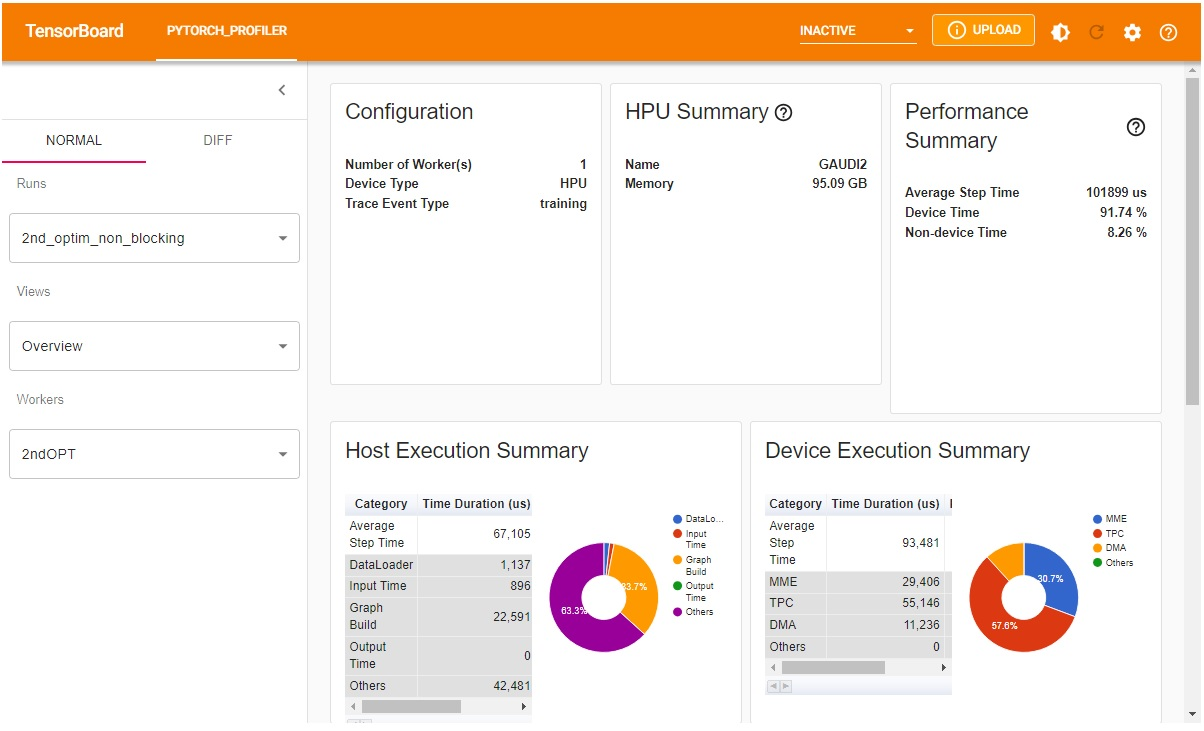

In [15]:
from IPython.display import Image
img_path = 'tensorboard.jpg'
display(Image(img_path))